In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=5a7f799b98cfdb5c98625b64d73e298931202f1d8f4fdf05121e2a491f7805e3
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install kmodes

In [3]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("K=prototype local") \
    .getOrCreate()

sc = spark.sparkContext

Lets read the data!

The dataset consists of obesity related features and we are going to perform clustering! Originally, the dataset had 7 clusters!

In [4]:
df = spark.read.csv('data.csv',inferSchema=True,header=True).cache()
df.show(5)

+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|     CAEC|SMOKE|CH2O|SCC|FAF|TUE|      CALC|              MTRANS|         NObeyesdad|
+------+----+------+------+------------------------------+----+----+---+---------+-----+----+---+---+---+----------+--------------------+-------------------+
|Female|21.0|  1.62|  64.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|0.0|1.0|        no|Public_Transporta...|      Normal_Weight|
|Female|21.0|  1.52|  56.0|                           yes|  no| 3.0|3.0|Sometimes|  yes| 3.0|yes|3.0|0.0| Sometimes|Public_Transporta...|      Normal_Weight|
|  Male|23.0|   1.8|  77.0|                           yes|  no| 2.0|3.0|Sometimes|   no| 2.0| no|2.0|1.0|Frequently|Public_Transporta...|      Normal_Weight|
|  Male|27.0|   1.8|  87.0|                         

In [10]:
from pyspark.sql.functions import countDistinct

df.select(countDistinct("NObeyesdad").alias(' cluster count')).show()

+--------------+
| cluster count|
+--------------+
|             7|
+--------------+



In [11]:
df_spark = df.drop(df.NObeyesdad)

Get the categorical and numerical columns listto use in the k-prototype


In [12]:
pd_df = df_spark.toPandas()
pd_df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation


In [13]:
pd_df.nunique()

Gender                               2
Age                               1402
Height                            1574
Weight                            1525
family_history_with_overweight       2
FAVC                                 2
FCVC                               810
NCP                                635
CAEC                                 4
SMOKE                                2
CH2O                              1268
SCC                                  2
FAF                               1190
TUE                               1129
CALC                                 4
MTRANS                               5
dtype: int64

In [14]:
cat_columns = pd_df.select_dtypes('object').columns.tolist()
num_columns = pd_df.select_dtypes('number').columns.tolist()


In [15]:
num_columns

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

In [16]:
cat_columns

['Gender',
 'family_history_with_overweight',
 'FAVC',
 'CAEC',
 'SMOKE',
 'SCC',
 'CALC',
 'MTRANS']

In [17]:
train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=654321)

In [18]:
train_df.printSchema()

root
 |-- Gender: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Height: double (nullable = true)
 |-- Weight: double (nullable = true)
 |-- family_history_with_overweight: string (nullable = true)
 |-- FAVC: string (nullable = true)
 |-- FCVC: double (nullable = true)
 |-- NCP: double (nullable = true)
 |-- CAEC: string (nullable = true)
 |-- SMOKE: string (nullable = true)
 |-- CH2O: double (nullable = true)
 |-- SCC: string (nullable = true)
 |-- FAF: double (nullable = true)
 |-- TUE: double (nullable = true)
 |-- CALC: string (nullable = true)
 |-- MTRANS: string (nullable = true)



Kprototypes sequential approach

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 261, ncost: 280004.1958485212
Run: 1, iteration: 2/100, moves: 124, ncost: 265682.75395916984
Run: 1, iteration: 3/100, moves: 102, ncost: 256814.25265012766
Run: 1, iteration: 4/100, moves: 80, ncost: 250745.02549553264
Run: 1, iteration: 5/100, moves: 60, ncost: 247273.03050396842
Run: 1, iteration: 6/100, moves: 105, ncost: 236107.81147362082
Run: 1, iteration: 7/100, moves: 166, ncost: 216008.0083139162
Run: 1, iteration: 8/100, moves: 96, ncost: 210353.36747373577
Run: 1, iteration: 9/100, moves: 102, ncost: 203816.39392403132
Run: 1, iteration: 10/100, moves: 33, ncost: 203058.4175488943
Run: 1, iteration: 11/100, moves: 6, ncost: 203028.9964485768
Run: 1, iteration: 12/100, moves: 3, ncost: 203022.69673207757
Run: 1, iteration: 13/100, moves: 0, ncost: 203022.69673207757
Init: initializing cen

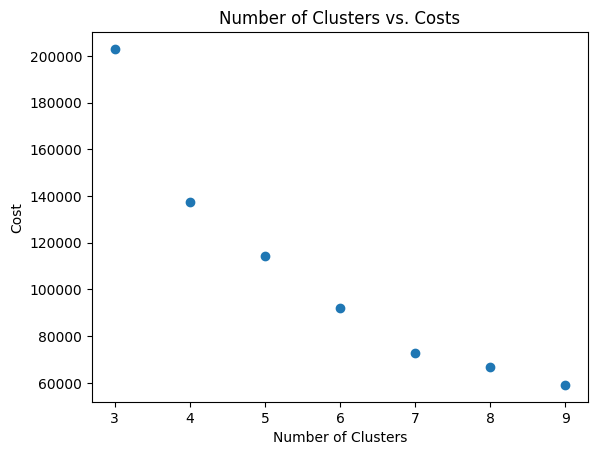

In [21]:
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
costs = []
n_clusters = []
clusters_assigned = []

cat_index = [train_df.columns.index(col) for col in cat_columns]
for i in range(3, 10):
    try:
        kproto = KPrototypes(n_clusters=i, init='Cao', verbose=2,random_state=20)
        clusters = kproto.fit_predict(train_df.toPandas(), categorical=cat_index)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")

plt.scatter(n_clusters, costs)
plt.xlabel('Number of Clusters')
plt.ylabel('Cost')
plt.title('Number of Clusters vs. Costs')
plt.show()

Predict on test_data


In [23]:
from kmodes.kprototypes import KPrototypes
import pandas as pd


cat_index = [train_df.columns.index(col) for col in cat_columns]

kproto = KPrototypes(n_clusters=7, init='Cao', verbose=2)
clusters_train = kproto.fit_predict(train_df.toPandas(), categorical=cat_index)

clusters_test = kproto.predict(test_df.toPandas(), categorical=cat_index)

clusters_df = pd.DataFrame(clusters_test, columns=["cluster"])

clusters_spark_df = spark.createDataFrame(clusters_df)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 408, ncost: 102638.96826190544
Run: 1, iteration: 2/100, moves: 282, ncost: 87329.29250892044
Run: 1, iteration: 3/100, moves: 130, ncost: 83215.04793235907
Run: 1, iteration: 4/100, moves: 86, ncost: 81273.71841639551
Run: 1, iteration: 5/100, moves: 75, ncost: 79201.02178496856
Run: 1, iteration: 6/100, moves: 133, ncost: 75292.65512085873
Run: 1, iteration: 7/100, moves: 68, ncost: 74003.4009376616
Run: 1, iteration: 8/100, moves: 15, ncost: 73900.25932022263
Run: 1, iteration: 9/100, moves: 10, ncost: 73852.27218512194
Run: 1, iteration: 10/100, moves: 19, ncost: 73610.9641774515
Run: 1, iteration: 11/100, moves: 21, ncost: 73444.7615103402
Run: 1, iteration: 12/100, moves: 7, ncost: 73414.3192483612
Run: 1, iteration: 13/100, moves: 13, ncost: 73183.05150725895
Run: 1, iteration: 14/100, moves: 

In [24]:
import pandas as pd
test_pd = pd.concat([test_df.toPandas(), clusters_df], ignore_index=True,axis=1)
test_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,Female,16.000000,1.550000,45.000000,no,yes,2.000000,3.00000,Frequently,no,2.000000,no,1.000000,1.000000,no,Public_Transportation,5
1,Female,16.000000,1.660000,58.000000,no,no,2.000000,1.00000,Sometimes,no,1.000000,no,0.000000,1.000000,no,Walking,4
2,Female,16.240576,1.616533,65.062945,yes,yes,2.388168,1.00000,Sometimes,no,1.438018,yes,0.110887,1.165817,no,Public_Transportation,4
3,Female,16.380090,1.617124,67.913561,yes,yes,2.851664,1.00000,Sometimes,no,2.000000,no,0.977929,1.765321,no,Public_Transportation,4
4,Female,16.928791,1.710948,45.248627,no,yes,2.910733,3.12544,Sometimes,no,2.204263,no,2.407906,1.403037,Sometimes,Public_Transportation,5


In [25]:
kproto.cost_

72961.66079214295

## Local approach

In [26]:
train_df, test_df = df_spark.randomSplit([0.7, 0.3], seed=654321)
train_rdd = train_df.rdd.repartition(3).cache()
test_rdd = test_df.rdd.repartition(2).cache()

Re-partitioning due to small data


In [28]:
all_columns = train_df.columns
cat_index = [train_df.columns.index(col) for col in cat_columns]


def build_model(partition_iter):
  partition_df = pd.DataFrame(partition_iter, columns=all_columns)
  kproto = KPrototypes(n_clusters=7, init='Cao', verbose=2,random_state=20)
  clusters_train = kproto.fit_predict(partition_df, categorical=cat_index)

  return [kproto]

models = train_rdd.mapPartitions(build_model).collect()
models

[KPrototypes(gamma=2.197643157078472, n_clusters=7, random_state=20, verbose=2),
 KPrototypes(gamma=2.3517209050624324, n_clusters=7, random_state=20, verbose=2),
 KPrototypes(gamma=2.2187192776914584, n_clusters=7, random_state=20, verbose=2)]

In [29]:
import numpy as np
def predict(instance):
    instance_np = np.array(instance)

    predictions = [m.predict(instance_np.reshape(1, -1), categorical=cat_index)[0] for m in models]

    return predictions

Aggregating the results using mode! this is like majority voting

In [30]:
from statistics import mode

def agg_predictions(predictions):
    return mode(predictions)

clusters_pred = test_rdd.map(predict).map(agg_predictions).collect()

In [31]:
from pyspark.sql import Row
def transform(instance):

  return Row(**instance.asDict(),\
    raw_prediction=float(agg_predictions(predict(instance))))


In [32]:
pred_df = test_rdd.map(transform).toDF()
pred_df.show(5)

+------+---------+--------+---------+------------------------------+----+--------+--------+----------+-----+--------+---+--------+--------+---------+--------------------+--------------+
|Gender|      Age|  Height|   Weight|family_history_with_overweight|FAVC|    FCVC|     NCP|      CAEC|SMOKE|    CH2O|SCC|     FAF|     TUE|     CALC|              MTRANS|raw_prediction|
+------+---------+--------+---------+------------------------------+----+--------+--------+----------+-----+--------+---+--------+--------+---------+--------------------+--------------+
|Female|17.767432| 1.74379|     50.0|                            no| yes|1.344854|     4.0|Frequently|   no|     1.0| no|     2.0|     1.0|Sometimes|Public_Transporta...|           3.0|
|Female|17.807828|1.518067|55.822119|                            no| yes|1.773265|2.118153| Sometimes|   no|1.075239|yes|0.085388|1.915191|Sometimes|Public_Transporta...|           3.0|
|Female|17.823438|1.708406|     50.0|                            no| y